In [2]:
import numpy as np
import pandas as pd
import itertools
from scipy import linalg
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [3]:
# 解决中文显示问题
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
%matplotlib inline

In [5]:
# 画图时用以边界的扩充
def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d

In [17]:
## 样本数据产生
n_samples = 500

np.random.seed(28)
C = np.array([[0., -0.1], [1.7, .4]])
# C：
# array([[ 0. , -0.1],
#        [ 1.7,  0.4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C), .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
# X shape:(1000, 2)

In [18]:
# np.random.randn(n_samples, 2)  # shape:500,2
# np.dot(np.random.randn(n_samples, 2), C).shape  # (500, 2)
# .7 * np.random.randn(n_samples, 2)  # (500, 2)
# .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])
# np.r_[[[1,2],[3,4]], [[5,6],[7,8]]]
# X.shape

In [19]:
## 不同参数效果比较
lowest_bic = np.infty
bics = []
n_components_range = range(1, 7)
# 四种协方差的类型
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    # 元素范围
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        # gmm.bic为：贝叶斯信息准则，越小越好
        bics.append(gmm.bic(X))
        if bics[-1] < lowest_bic:
            lowest_bic = bics[-1]
            best_gmm = gmm

# 获取相关参数以及最优算法
clf = best_gmm
Y_ = clf.predict(X)

print ("均值:\n", clf.means_)
print ("方差:\n", clf.covariances_)

均值:
 [[-5.96170456  3.0078179 ]
 [-0.03908874 -0.00864228]]
方差:
 [[[0.52760145 0.02227373]
  [0.02227373 0.49288209]]

 [[2.59795894 0.61525644]
  [0.61525644 0.156022  ]]]


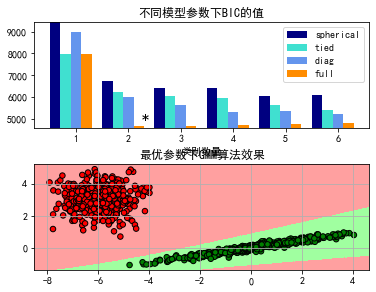

In [21]:
# 画图
bics = np.array(bics)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

## 画出效果比较
spl = plt.subplot(2, 1, 1)
bars = []
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bics[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bics.min() * 1.01 - .01 * bics.max(), bics.max()])
plt.title(u'不同模型参数下BIC的值')
xpos = np.mod(bics.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bics.argmin() / len(n_components_range))
plt.text(xpos, bics.min() * 0.97 + .03 * bics.max(), '*', fontsize=14)
spl.set_xlabel(u'类别数量')
spl.legend([b[0] for b in bars], cv_types)

# 画出分类效果图（可以看到最优分类是2）
splot = plt.subplot(2, 1, 2)
cm_light = mpl.colors.ListedColormap(['#FFA0A0', '#A0FFA0'])
cm_dark = mpl.colors.ListedColormap(['r', 'g'])

x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)
grid_hat = clf.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
if clf.means_[0][0] > clf.means_[1][0]:
    z = grid_hat == 0
    grid_hat[z] = 1
    grid_hat[~z] = 0

# 底色绘制
plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light)
# 原始X数据绘制
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y_, marker='o', cmap=cm_dark, edgecolors='k')
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.title(u'最优参数下GMM算法效果')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.grid()

plt.show()